# <div align="center"><b> Desafio 3 - Procesamiento del lenguaje Natural - CEIA </b></div>


<div align="right">📝 <em><small><font color='Gray'>Nota:</font></small></em></div>

<div align="right"> <em><small><font color='Gray'> La funcionalidad de visualización de jupyter notebooks en <a href="https://github.com/" target="_blank">github</a> es solamente un preview.</font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Para mejor visualización se sugiere utilizar el visualizador recomndado por la comunidad: <a href="https://nbviewer.org/" target="_blank">nbviewer</a></font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Puedes a acceder al sigiente enlace para ver este notebook en dicha página: <a href="https://nbviewer.org/github/brunomaso1/uba-ceia/blob/ceia-nlp/ceia-nlp/Desafio%203.ipynb">Desafio 3</a></font></small></em> </div>


---


In [1]:
# Descargamos la carpeta con archivos auxiliares (Colab)
# %pip install gdown
# !gdown https://drive.google.com/drive/folders/1hNPqr6g3opu9u-UwnngVcyxUUzfmKZdT?usp=sharing --folder

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>


<!-- Colab -->
<!-- <div align="center"><img src="https://drive.google.com/uc?export=view&id=1QSNrTsz1hQbmZwpgwx0qpfpNtLW19Orm" width="600" alt="Figura 1: A data scientist is working on word generation using the Lord of the Rings lore. The image is dark and moody, with a focus on the scientist's computer screen. The screen displays a visualization the one ring, with a map of Middle Earth in the background. - Generada con DALL-E3"></div> -->

<div align="center"><img src="./resources/Desafio_3_portada.jpg" width="600" alt="Figura 1: A data scientist is working on word generation using the Lord of the Rings lore. The image is dark and moody, with a focus on the scientist's computer screen. The screen displays a visualization the one ring, with a map of Middle Earth in the background. - Generada con DALL-E3"></div>

<div align="center"><small><em>Figura 1: A data scientist is working on word generation using the Lord of the Rings lore. The image is dark and moody, with a focus on the scientist's computer screen. The screen displays a visualization the one ring, with a map of Middle Earth in the background. - Generada con DALL-E3</em></small></div>


<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| Subtitulo       | Desafío 3 - NLP - FIUBA               |
| --------------- | ------------------------------------- |
| **Descrpción**  | Model language                        |
| **Integrantes** | Bruno Masoller (brunomaso1@gmail.com) |

</div>


✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋


In [2]:
import numpy as np
import os
import re
import glob
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import pad_sequence
from math import sqrt
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy, sparse_categorical_crossentropy
from tensorflow.keras.saving import register_keras_serializable
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, GRU, Dropout
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import TimeDistributed, CategoryEncoding, SimpleRNN, Masking
from keras.models import Model, load_model
from scipy.special import softmax
from tensorflow.keras.regularizers import l2

🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [3]:
VERBOSE = False  # Si se muestra todo el entrenamiento de Gensim
EPOCHS = 50  # Épocas a entrenar
RANDOM_SEED = 42  # Semilla de random
TRAIN_TEST_SPLIT_RATIO = 0.2
BATCH_SIZE = 64
PATIENCE = 10
WORD_MODEL_FILEPATH = 'resources/word_model.keras'
CHAR_MODEL_FILEPATH = 'resources/char_model.keras'

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to C:\Users\Ferchita-
[nltk_data]     Maso\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Ferchita-
[nltk_data]     Maso\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Ferchita-
[nltk_data]     Maso\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ferchita-
[nltk_data]     Maso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Ferchita-
[nltk_data]     Maso\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Consigna del desafío


### Parte 1 

- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus en palabras, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

### Parte 2 

- Realizar el pre-procesamiento adecuado para tokenizar el corpus en base a carácteres, estructurar el dataset y separar entre datos de entrenamiento y validación.

## Resolución


### Parte 1


> - Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
> - Realizar el pre-procesamiento adecuado para tokenizar el corpus en palabras, estructurar el dataset y separar entre datos de entrenamiento y validación.
> - Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
> - Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

#### Pre-procesamiento

<em><p>

Para este desafío, utilizaremos 5 de las obras de tolkien para generar un modelo del lenguaje. Las obras son:
- La comunidad del anillo
- El hobbit
- El retorno del rey
- Las dos torres
- El silmarillon

</p></em>

*Inicialmente, cargamos los textos. Como estos fueron "extraídos (🏴‍☠️)", los pre-procesamos para eliminar la metadata:*

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Carga los textos de un directorio</p></font></em>

In [4]:
def importar_textos(ruta, textos_validos) -> pd.DataFrame:
    pattern = re.compile(r'([^\\\/]+)(?=\.txt$)')
    data = []
    
    for filename in glob.glob(os.path.join(ruta, '*.txt')):
        # Extraer el nombre del archivo sin la extensión
        file_name = pattern.search(filename).group(0)
        
        if file_name in textos_validos:
            # Abrir el archivo y leer su contenido
            with open(filename, 'r', encoding='utf-8') as f:
                full_text = f.read()
                
                # Obtener los índices para este archivo desde `textos_validos`
                start_idx, end_idx = textos_validos[file_name]
                
                # Extraer el texto entre los índices especificados
                extracted_text = full_text[start_idx:end_idx]
                
                # Dividir el texto por más de un salto de línea
                paragraphs = re.split(r'\n{2,}', extracted_text)
                
                # Agregar cada párrafo como una nueva fila en la lista de datos
                for paragraph in paragraphs:
                    data.append({
                        'file_name': file_name,
                        'extracted_text': paragraph.strip()  # Remover espacios innecesarios
                    })
        else:
            print(f"Archivo {file_name} no está en textos_validos.")

    # Convertir la lista de datos en un DataFrame
    df = pd.DataFrame(data)
    
    return df


*Cargamos los textos en un dataframe:*

In [5]:
# Visualmente nos fijamos desde donde y hasta donde tomar los textos para evitar la meta-data.
textos_validos = {
    'fellowship': (43242, -5436),
    'silmarillion': (43190, -5436),
    'hobbit': (43212, -8543),
    'return': (43252, -5434),
    'twotowers': (43302, -19245)
}

path = './resources/lotr_books/'
df = importar_textos(path, textos_validos)
df

,file_name,extracted_text
0,fellowship,“THE LORD OF THE RINGS'
1,fellowship,Part One
2,fellowship,THE FELLOWSHIP \nOF THE RING
3,fellowship,J.R.R.ToIkien
4,fellowship,Complete Table of Contents
...,...,...
15593,twotowers,THE CHOICES OF MASTER SAMWISE 971
15594,twotowers,"Sam heard a burst of hoarse singing, blaring o..."
15595,twotowers,"Sam yelled and brandished Sting, but his littl..."
15596,twotowers,The great doors slammed to. Boom. The bars of ...


*Nos quedamos solo con los textos:*

In [6]:
df = pd.DataFrame(df['extracted_text'])
df

,extracted_text
0,“THE LORD OF THE RINGS'
1,Part One
2,THE FELLOWSHIP \nOF THE RING
3,J.R.R.ToIkien
4,Complete Table of Contents
...,...
15593,THE CHOICES OF MASTER SAMWISE 971
15594,"Sam heard a burst of hoarse singing, blaring o..."
15595,"Sam yelled and brandished Sting, but his littl..."
15596,The great doors slammed to. Boom. The bars of ...


_Verificamos la información del cojunto:_


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15598 entries, 0 to 15597
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   extracted_text  15598 non-null  object
dtypes: object(1)
memory usage: 122.0+ KB


*Para la limpieza del conjunto, lo pasamos por varias expresiones regulares que se identificaron (mediante visualización de los texto) que son términos que se quieren eliminar, dado que el texto fue convertido del html:*

In [8]:
def eliminar_terminos_con_patrones(df: pd.DataFrame, patrones: list) -> pd.DataFrame:
    # Función auxiliar para reemplazar términos que coinciden con alguno de los patrones
    def reemplazar_terminos(texto, patrones):
        # Separar el texto en palabras
        palabras = texto.split()
        # Reemplazar las palabras que coincidan con alguno de los patrones
        palabras_limpias = []
        for palabra in palabras:
            reemplazar = False
            for patron in patrones:
                if patron.match(palabra):
                    reemplazar = True
                    break
            # Si coincide con algún patrón, se sustituye por "", de lo contrario se mantiene la palabra
            palabras_limpias.append("" if reemplazar else palabra)
        # Unir las palabras de nuevo en una sola cadena
        return " ".join(palabras_limpias)
    
    # Aplicar la función de reemplazo a la columna 'extracted_text'
    df['extracted_text'] = df['extracted_text'].apply(lambda texto: reemplazar_terminos(texto, patrones))
    
    return df

In [9]:
# Ejemplo de patrones a utilizar
numero_numero_pattern = re.compile(r'^(\d+-)+\d+$')  # Números separados por guiones
numero_punto_pattern = re.compile(r'^\d+\.$')  # Números seguidos de un punto

# Lista de patrones
patrones = [numero_numero_pattern, numero_punto_pattern]

# Llamar a la función con la lista de patrones
df = eliminar_terminos_con_patrones(df, patrones)

*Chequeamos si el conjunto tiene filas vacías:*

In [10]:
filas_vacias = 0
for _, row in df[:None].iterrows():
    filas_vacias += row.iloc[0] == ""
filas_vacias

5

*Eliminamos las filas vacías:*

In [11]:
# Eliminar filas donde la columna 'extracted_text' tenga valores vacíos ("")
df = df[df['extracted_text'] != ""]

#### Tokenizar

_Una vez que tenemos todo el script, realizaremos el pre-procesamiento convieriendo los documentos (cada linea) en tokens._


🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'>Realiza el procesamiento de las sentencias utilizando NLTK (https://www.nltk.org/)</font></em>


```python
# Proceso completo ->
def nltk_process(text):
    lemmatizer = WordNetLemmatizer()

    # Convertir todo el texto a minúsculas
    filtered_sentence = text.lower()

    # Eliminar saltos de línea
    filtered_sentence = re.sub(r'\n', ' ', filtered_sentence)

    # Tokenization
    filtered_sentence = word_tokenize(filtered_sentence)

    # Lemmatization
    filtered_sentence = [lemmatizer.lemmatize(word) for word in filtered_sentence]

    # Stop words
    nltk_stop_words = stopwords.words("english")
    filtered_sentence = [w for w in filtered_sentence if w not in nltk_stop_words]

    # Filter Punctuation
    filtered_sentence = [w for w in filtered_sentence if w not in string.punctuation]

    return filtered_sentence
```

In [12]:
# Proceso simplificado ->
def nltk_process(text):
    # Convertir todo el texto a minúsculas
    filtered_sentence = text.lower()

    # Eliminar saltos de línea
    filtered_sentence = re.sub(r'\n', ' ', filtered_sentence)

    # Tokenization
    filtered_sentence = word_tokenize(filtered_sentence)

    return filtered_sentence

_Pre-procesamos las sentencias:_


In [13]:
segmented_sentences = []
for _, row in df[:None].iterrows():
    segmented_sentences.append(nltk_process(row.iloc[0]))

_Chequeamos algunas sentencias al azar:_


In [14]:
rng = np.random.default_rng(seed=RANDOM_SEED)

for i in range(5):
    random_index = rng.integers(len(segmented_sentences))
    print(segmented_sentences[random_index])

['suddenly', 'tom', '’', 's', 'talk', 'left', 'the', 'woods', 'and', 'went', 'leaping', 'up', 'the', 'young', 'stream', ',', 'over', 'bubbling', 'waterfalls', ',', 'over', 'pebbles', 'and', 'worn', 'rocks', ',', 'and', 'among', 'small', 'flowers', 'in', 'close', 'grass', 'and', 'wet', 'crannies', ',', 'wandering', 'at', 'last', 'up', 'on', 'to', 'the', 'downs', '.', 'they', 'heard', 'of', 'the', 'great', 'barrows', ',', 'and', 'the', 'green', 'mounds', ',', 'and', 'the', 'stone-rings', 'upon', 'the', 'hills', 'and', 'in', 'the', 'hollows', 'among', 'the', 'hills', '.', 'sheep', 'were', 'bleating', 'in', 'flocks', '.', 'green', 'walls', 'and', 'white', 'walls', 'rose', '.', 'there', 'were', 'fortresses', 'on', 'the', 'heights', '.', 'kings', 'of', 'little', 'kingdoms', 'fought', 'together', ',', 'and', 'the', 'young', 'sun', 'shone', 'like', 'fire', 'on', 'the', 'red', 'metal', 'of', 'their', 'new', 'and', 'greedy', 'swords', '.', 'there', 'was', 'victory', 'and', 'defeat', ';', 'and', 

_Chequeamos la cantidad de sentencias_


In [15]:
len(segmented_sentences)

15593

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Construye el vocabulario a partir de términos de sentencias</p></font></em>

In [16]:
# Construir el vocabulario (similar a fit_on_texts en Keras)
def build_vocab(segmented_sentences):
    # Se deja el indice 0 para el padding
    vocab = defaultdict(lambda: 1)  # Índice 0 reservado para OOV
    index = 2  # Comenzamos los índices desde 2
    
    for sentence in segmented_sentences:
        for word in sentence:
            if word not in vocab:
                vocab[word] = index
                index += 1
                
    return vocab

*Creamos el vocabulario:*

In [17]:
# Crear vocabulario
vocab = build_vocab(segmented_sentences)

In [18]:
print("Tamaño inicial del vocabulario:")
len(dict(vocab))

Tamaño inicial del vocabulario:


21315

In [19]:
print("Vocabulario:")
dict(vocab)

Vocabulario:


{'“': 2,
 'the': 3,
 'lord': 4,
 'of': 5,
 'rings': 6,
 "'": 7,
 'part': 8,
 'one': 9,
 'fellowship': 10,
 'ring': 11,
 'j.r.r.toikien': 12,
 'complete': 13,
 'table': 14,
 'contents': 15,
 'foreword': 16,
 'prologue': 17,
 '1': 18,
 '.': 19,
 'concerning': 20,
 'hobbits': 21,
 'pipe-weed': 22,
 'ordering': 23,
 'shire': 24,
 'finding': 25,
 'note': 26,
 'on': 27,
 'records': 28,
 'book': 29,
 'i': 30,
 'chapter': 31,
 '2': 32,
 '3': 33,
 '4': 34,
 '5': 35,
 '6': 36,
 '7': 37,
 '8': 38,
 '9': 39,
 '10': 40,
 '11': 41,
 '12': 42,
 'a': 43,
 'long-expected': 44,
 'party': 45,
 'shadow': 46,
 'past': 47,
 'three': 48,
 'is': 49,
 'company': 50,
 'short': 51,
 'cut': 52,
 'to': 53,
 'mushrooms': 54,
 'conspiracy': 55,
 'unmasked': 56,
 'old': 57,
 'forest': 58,
 'in': 59,
 'house': 60,
 'tom': 61,
 'bombadil': 62,
 'fog': 63,
 'barrow-downs': 64,
 'at': 65,
 'sign': 66,
 'prancing': 67,
 'pony': 68,
 'strider': 69,
 'knife': 70,
 'dark': 71,
 'flight': 72,
 'ford': 73,
 'ii': 74,
 'many': 

*Como una visualización rápida, podemos encontrar términos "raros":*

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Muestra términos que son "raros" del vocabulario.</p></font></em>

In [20]:
def mostrar_terminos_raros(vocab):
    terminos_raros = []
    
    # Expresión regular para detectar términos que contienen algo distinto de letras o números
    pattern = re.compile(r'[^a-zA-Z0-9]')
    
    for palabra in vocab:
        if pattern.search(palabra):
            terminos_raros.append(palabra)
    
    return terminos_raros

*Mostramos estos términos raros del vocabulario:*

In [21]:
# Mostrar los términos raros del vocabulario
terminos_raros = mostrar_terminos_raros(vocab)

print("Términos raros en el vocabulario:")
terminos_raros

Términos raros en el vocabulario:


['“',
 "'",
 'j.r.r.toikien',
 '.',
 'pipe-weed',
 'long-expected',
 'barrow-downs',
 'khazad-dym',
 'urak-hai',
 "'s",
 'cross-roads',
 ',',
 ';',
 "'history",
 ':',
 'high-elves',
 '’',
 're-written',
 're-typed',
 'ten-fingered',
 'tale-teller',
 "'message",
 '(',
 ')',
 '``',
 'barad-dyr',
 'ring-lore',
 'self-styled',
 'middle-earth',
 "'applicability",
 "'allegory",
 'story-germ',
 'motor-cars',
 'corn-mill',
 'mrs.',
 'n.',
 '*',
 'hobbit-lore',
 'well-ordered',
 'well-farmed',
 '-bellows',
 'water-mill',
 'hand-loom',
 "'the",
 'sharp-eyed',
 'shoe-making',
 'good-natured',
 'bright-eyed',
 'red-cheeked',
 '-earth',
 'north-west',
 'd®nedain',
 'shire-reckoning',
 'witch-lord',
 's.r',
 '1158-60',
 'mathom-house',
 'well-fed',
 'keen-eyed',
 'well-to-do',
 'low-lying',
 'heavy-legged',
 'dwarf-boots',
 'south-away',
 'elf-towers',
 '-building',
 'hobbit-architecture',
 'shire-hobbits',
 '-tunnelled',
 '-trees',
 '-tree',
 "'art",
 "'is",
 'home-grown',
 "'how",
 'bree-hobbits',

*Vemos que hay muchos términos que son raros. Esto tiene sentido dado el procesamiento de los textos (se los obtuvo de una página html), a demás, teniendo en cuenta el contexto, Tolkien creó varios lenguajes, que no fueron correctamente interpretados, como por ejemplo el símbolo ®.

*Finalmente, convertimos las sentencias en tokens:*

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Convierte sentencias en tokens</p></font></em>

In [22]:
# Convertir oraciones en secuencias de números, asignando 0 para palabras fuera del vocabulario
def texts_to_sequences_nltk(segmented_sentences, vocab):
    return [[vocab.get(word, 0) for word in sentence] for sentence in segmented_sentences]

*Convertir las oraciones procesadas en secuencias de números:*

In [23]:
tokenized_sentences = texts_to_sequences_nltk(segmented_sentences, vocab)

*Secuencias tokenizadas:*

In [24]:
for tok in tokenized_sentences:
    if max(tok) == len(vocab):
        print(max(tok))

21315


In [25]:
tokenized_sentences

[[2, 3, 4, 5, 3, 6, 7],
 [8, 9],
 [3, 10, 5, 3, 11],
 [12],
 [13, 14, 5, 15],
 [16],
 [17],
 [18, 19, 20, 21],
 [20, 22],
 [5, 3, 23, 5, 3, 24],
 [5, 3, 25, 5, 3, 11],
 [26, 27, 3, 24, 28],
 [29, 30],
 [31,
  18,
  31,
  32,
  31,
  33,
  31,
  34,
  31,
  35,
  31,
  36,
  31,
  37,
  31,
  38,
  31,
  39,
  31,
  40,
  31,
  41,
  31,
  42],
 [43,
  44,
  45,
  3,
  46,
  5,
  3,
  47,
  48,
  49,
  50,
  43,
  51,
  52,
  53,
  54,
  43,
  55,
  56,
  3,
  57,
  58],
 [59, 3, 60, 5, 61, 62, 63, 27, 3, 64, 65, 3, 66, 5, 3, 67, 68, 69],
 [43, 70, 59, 3, 71, 72, 53, 3, 73],
 [29, 74],
 [31,
  18,
  31,
  32,
  31,
  33,
  31,
  34,
  31,
  35,
  31,
  36,
  31,
  37,
  31,
  38,
  31,
  39,
  31,
  40],
 [75, 76, 3, 77, 5, 78, 3, 11, 79, 80, 43, 81, 59, 3, 71, 3, 82, 5, 83, 84],
 [3, 85, 5, 86, 87, 53, 88, 3, 89, 90, 3, 91, 5, 3, 10],
 [29, 92],
 [31,
  18,
  31,
  32,
  31,
  33,
  31,
  34,
  31,
  35,
  31,
  36,
  31,
  37,
  31,
  38,
  31,
  39,
  31,
  40,
  31,
  41],
 [3, 93, 

*Observamos una sentencia tokenizada:*

In [26]:
print(f"Sentencia segmentada: {segmented_sentences[0]}")
print(f"Sentencia tokenizada: {tokenized_sentences[0]}")

Sentencia segmentada: ['“', 'the', 'lord', 'of', 'the', 'rings', "'"]
Sentencia tokenizada: [2, 3, 4, 5, 3, 6, 7]


#### Tamaño del contexto

*Obtenemos la longitud de cada sentencia:*

In [27]:
length_sentences = [len(sentence) for sentence in segmented_sentences]

*Vemos la distribución de las sentencias:*

<Axes: ylabel='Count'>

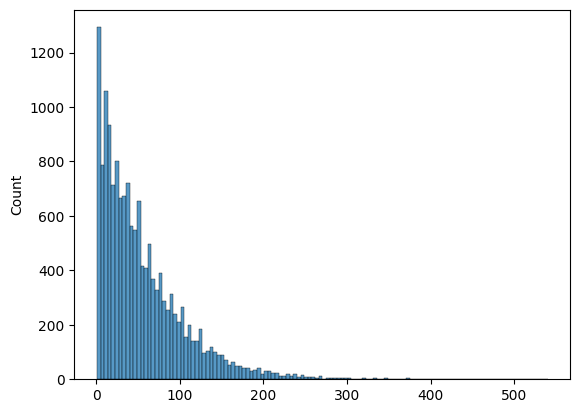

In [28]:
sns.histplot(length_sentences, bins=int(sqrt(len(length_sentences))))

*Elegimos un contexto máximo:*

*Primero, investigamos algunas métricas para elegir un posible contexto:*

In [29]:
print(f"Percentil 90: {int(np.percentile(length_sentences, 90)-1)}")
print(f"Meida: {int(np.ceil(np.mean(length_sentences)))}")
print(f"Mediana: {int(np.ceil(np.median(length_sentences)))}")

Percentil 90: 122
Meida: 56
Mediana: 42


*Elegimos la mediana en este caso:*

In [30]:
max_context_size = int(np.ceil(np.median(length_sentences)))
print(f"max_context_size: {max_context_size}")

max_context_size: 42


#### Modelado y entrenamiento

*Inicialmente, dividimos nuestro conjunto en entrenamiento y validación:*

In [31]:
tok_sent_train, tok_sent_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=TRAIN_TEST_SPLIT_RATIO, random_state=RANDOM_SEED)

##### Data-augmentation

*Para aumentar la cantidad de datos, generamos más secuencias si son mayores al contexto maximo dividiendolas en sub-secuencias:*

In [32]:
tok_sent_train_augmented = []

for sent in tok_sent_train:
    # si la secuencia tiene más términos que el tamaño de contexto máximo,
    # armo varias sub-secuencias de tamaño máximo
    if len(sent) > (max_context_size + 1):
        extra = len(sent) - (max_context_size + 1) + 1
        for i in range(extra):
            tok_sent_train_augmented.append(sent[i : i + max_context_size + 1])
    else:  # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
        tok_sent_train_augmented.append(sent)

In [33]:
print(f'Cantidad de sentencias tokenizadas aumentadas: {len(tok_sent_train_augmented)}')

Cantidad de sentencias tokenizadas aumentadas: 315957


📝 <em><font color='Gray'>Nota:</font></em>
<em><font color='Gray'><p>Podríamos aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas, pero en este caso no es necesario.</p></font></em>

```python
# Ejemplo:
seq = []

for sent in tok_sent:
    subseq = [sent[: i + 2] for i in range(len(sent) - 1)]
    seq.append(subseq)
```

*Hacemos padding para los casos de secuencias menores al contexto:*

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Paddea y corta una secuencia utilizando NLTK</p></font></em>

In [34]:
def pad_and_crop_seq(seq, maxlen, padding_value=0):
    # Aplicar padding utilizando nltk.pad_sequence, le agrega los caracteres, después hay que truncar los caracteres sobrantes.
    padded_seq = list(pad_sequence(seq, maxlen, pad_left=False, pad_right=True, left_pad_symbol=None, right_pad_symbol=padding_value))

    # Truncar la secuencia si es más larga que maxlen
    if len(padded_seq) > maxlen:
        padded_seq = padded_seq[:maxlen]

    return padded_seq

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Realiza padding a una lista de sequencias</p></font></em>

In [35]:
def pad_sequences_nltk(sequences, maxlen, padding_value=0):
    padded_sequences = []

    for seq in sequences:
        if len(seq) < maxlen:
            padded_seq = pad_and_crop_seq(seq, maxlen, padding_value)
        else:
            padded_seq = seq[-maxlen:]
        padded_sequences.append(padded_seq)
    return np.array(padded_sequences)

*Aplicamos el padding:*

In [36]:
tok_sent_train_augm_padded = pad_sequences_nltk(tok_sent_train_augmented, max_context_size + 1)
tok_sent_val_padded = pad_sequences_nltk(tok_sent_val, max_context_size + 1)
print(f"Ejemplo de secuencia con padding aplicada (entrenamiento):\n{tok_sent_train_augm_padded[0]}")

Ejemplo de secuencia con padding aplicada (entrenamiento):
[   59     3  1344   110  6597   387     5  7369     3   762     5     3
    29    30   190   841  1777 14855   259 14856 14857   177   314  8293
   205   336    59 14858    19     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


*Para el modelado, estructuramos el problema de aprendizaje en un many-to-many:*

📝 <em><font color='Gray'>Nota:</font></em>
<em><font color='Gray'><p>Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.</p></font></em>

*Ajustamos los datos de entrenamiento y validación:*

🤖 <em><font color='DarkGoldenRod'>Consulta a IA (ChatGPT 4o):</font></em> 🤖

❔ <em><font color='GoldenRod'>Prompt:</font></em>
<em><font color='GoldenRod'><p>Cual es el proceso correcto para generar los conjuntos de validación?
Actualmente, los genero antes de hacer el padding y cortar las sentencias de training:

tok_sent_train, tok_sent_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=TRAIN_TEST_SPLIT_RATIO, random_state=RANDOM_SEED)

Si hago este proceso en validación, creo que no es correcto, ya que estoy "tocando" dicho conjunto. 

Tienes alguna sugerencia para solucionar este problema y evitar que se filtre información al conjunto de validación? Entiendo que de alguna forma hay que llevarlas al tamaño del contexto máximo, que es la entrada de mi red...

Se me ocurre lo siguiente. Para los casos en donde la sentencia de validación es más chica que el contexto máximo, le aplico padding hasta el contexto máximo. Para el resto de los casos, las corto, pero partiendo desde el final hasta el principio. Que te parece?</p></font></em>

🔃 <em><font color='BurlyWood'>Respuesta:</font></em>
<em><font color='BurlyWood'><p>Tienes razón en preocuparte por la forma en que se maneja el conjunto de validación para evitar la "filtración de información", especialmente cuando se manipulan las secuencias de entrada, ya que tocar el conjunto de validación de manera incorrecta puede sesgar los resultados.
Solución propuesta:

Tu enfoque de aplicar padding a las secuencias más cortas y truncar desde el final a las más largas es adecuado y sigue las buenas prácticas para evitar fugas de información entre los conjuntos de entrenamiento y validación. Voy a detallar por qué esta estrategia es válida y cómo podrías implementarla.

1. Padding a secuencias más cortas: Si una secuencia de validación es más corta que el contexto máximo que requiere tu modelo, agregar padding al final es una estrategia estándar en tareas de NLP. Esto asegura que todas las secuencias tienen la misma longitud sin introducir información adicional en el conjunto de validación.

2. Truncado desde el final: Truncar desde el final tiene sentido, ya que en muchas tareas de NLP (por ejemplo, modelos autoregresivos o de predicción de palabras), las palabras más recientes suelen ser más relevantes para el contexto actual. Truncar desde el principio podría hacer que pierdas contexto valioso, mientras que truncar desde el final mantiene las palabras más recientes, que son generalmente más relevantes para la predicción del siguiente token.

</p></font></em>

In [37]:
tok_sent_train_augm_padded = tok_sent_train_augm_padded[:80000, :]
tok_sent_val_padded = tok_sent_val_padded[:20000, :]

In [38]:
X = tok_sent_train_augm_padded[:, :-1]
y = tok_sent_train_augm_padded[:, 1:]
print(f'Shape X: {X.shape}')
print(f'Shape y: {y.shape}')

Shape X: (80000, 42)
Shape y: (80000, 42)


In [39]:
X_val = tok_sent_val_padded[:, :-1]
y_val = tok_sent_val_padded[:, 1:]
print(f'Shape X: {X_val.shape}')
print(f'Shape y: {y_val.shape}')

Shape X: (3119, 42)
Shape y: (3119, 42)


In [40]:
vocab_size = len(dict(vocab))
vocab_size

21315

##### Modelo

*Inicialmente, vamos a resolver el problema de la métrica "perplejidad":*

📝 <em><font color='Gray'>Nota:</font></em>
<em><font color='Gray'>
<p>En un principio, se creo un callback y se agregó dicho valor a los logs de keras, pero EarlyStopping no obtiene estas métricas (no se porqué, posiblemente porque se monitorizan por otro lado, habría que ver el código), por lo que se creó una métrica propia para la perpejidad. Se deja como había sido el caso anterior:</p></font></em>

```python
class PerplexityCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Obtener el loss del conjunto de validación
        val_loss = logs.get("val_loss")
        if val_loss is not None:
            # Calcular la perplejidad
            val_perplexity = np.exp(val_loss)
            # Añadir la perplejidad a los logs
            logs["val_perplexity"] = val_perplexity


perplexity_metric = PerplexityCallback()
```

*Creamos la métrica:*

In [41]:
# Definir la métrica personalizada para la perplejidad (hay que registrarla para que keras la serialize, sino no la guarda y da error cuando se carga el modelo)
@register_keras_serializable(package="Custom", name="perplexity")
def perplexity(y_true, y_pred):
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    # Esto lo tuve que hacer con tf porque con numpy tenía que transformarlo antes (loss.to_numpy())
    return tf.exp(tf.reduce_mean(loss))

*Chequeamos si ya hay un modelo previamente entrenado (o partimos desde el último entrenamiento) o en caso contrario generamos el modelo:*

In [42]:
try:
    model = load_model(WORD_MODEL_FILEPATH)
    print("Modelo pre-cargado")
except:
    model = Sequential()

    model.add(Embedding(input_dim=vocab_size + 1, output_dim=100, mask_zero=True))

    model.add(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))

    model.add(Dense(vocab_size + 1, activation="softmax", kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))

    model.build(input_shape=(None, max_context_size))
    print("Modelo nuevo")
finally:
    model.compile(
        loss=SparseCategoricalCrossentropy(), optimizer="rmsprop", metrics=[perplexity]
    )

    model.summary()

Modelo nuevo


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 42, 100)        │     2,131,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 42, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 42, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 42, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 42, 21316)      │     2,152,916 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,445,316 (16.96 MB)

 Trainable params: 4,445,316 (16.96 MB)

 Non-trainable params: 0 (0.00 B)

*Creamos un callback para definir la perplejidad, guardar el modelo y early stopping:*

In [43]:
# https://colab.research.google.com/github/Yash0330/Callbacks-in-Keras/blob/master/Introduction_to_callbacks.ipynb#scrollTo=eYmz1U150crs       
# Definir el callback de EarlyStopping que monitorea la perplejidad
early_stopping = EarlyStopping(
    monitor="val_perplexity",  # Monitorea la perplejidad en el conjunto de validación
    patience=PATIENCE,  # Detiene el entrenamiento si no mejora después de 3 épocas
    restore_best_weights=True,  # Restaura los mejores pesos al final del entrenamiento
    mode="min",  # La perplejidad debe disminuir
)

# Definir un callback para ir guardando el modelo
best_model = ModelCheckpoint(
    WORD_MODEL_FILEPATH, monitor="val_perplexity", mode="min", save_best_only=True
)

📝 <em><font color='Gray'>Nota:</font></em>
<em><font color='Gray'><p>Si quisieramos hacer un early stopping según la métrica de validación, podríamos utilizar lo siguiente:</p></font></em>

```python
# Definir el callback de EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida en el conjunto de validación
    patience=PATIENCE,          # Detiene el entrenamiento si no mejora después de 3 épocas
    restore_best_weights=True  # Restaura los mejores pesos al final del entrenamiento
)
```

<em><font color='Gray'><p>Sin embargo, para utilizar una métrica definida por nosotros (la perplejidad en este caso), se puede, o bien medir directamente en nuestra clase, o más fácil loguear el resultado y monitorizarlo con EarlyStopping (en este caso, se debe minimizar)</p></font></em>

##### Entrenamiento

*Realizamos el entrenamiento:*

In [44]:
hist = model.fit(
    X,
    y,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, best_model]
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1609s 1s/step - loss: 6.9243 - perplexity: 2336.8521 - val_loss: 6.4544 - val_perplexity: 852.5922
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1663s 1s/step - loss: 6.3083 - perplexity: 554.9825 - val_loss: 6.4396 - val_perplexity: 834.7339
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1612s 1s/step - loss: 6.2905 - perplexity: 546.4252 - val_loss: 6.4310 - val_perplexity: 879.7665
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1578s 1s/step - loss: 6.2829 - perplexity: 542.9777 - val_loss: 6.4300 - val_perplexity: 863.8312
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1576s 1s/step - loss: 6.2767 - perplexity: 539.9311 - val_loss: 6.4204 - val_perplexity: 828.1292
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1577s 1s/step - loss: 6.2704 - perplexity: 536.8984 - val_loss: 6.4262 - val_perplexity: 903.1097
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1580s 1s/step - loss: 6.2712 - perplexity: 537.3519 - val_loss: 6.4209 - val_perplexity: 895.6190
Epoch 8/50
1250/125

KeyboardInterrupt: 

*Realizamos las gráficas correspondientes:*

In [45]:
# Función para calcular la perplejidad
def calcular_perplejidad(loss):
    return np.exp(loss)

# Obtener los valores del historial de entrenamiento
history_dict = hist.history

# Extraer el loss y el val_loss (loss en validación)
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Extraer la perplejidad
perplexity = history_dict['perplexity']
val_perplexity = history_dict['val_perplexity']

# Definir las épocas
epochs = range(1, len(loss) + 1)

# Graficar el loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'ro-', label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Graficar la perplejidad
plt.subplot(1, 2, 2)
plt.plot(epochs, perplexity, 'bo-', label='Perplejidad de entrenamiento')
plt.plot(epochs, val_perplexity, 'ro-', label='Perplejidad de validación')
plt.title('Perplejidad durante el entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Perplejidad')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

NameError: name 'hist' is not defined

⭐ <em><strong>Conclusión</strong></em> ⭐

<em><strong><p>Como conclusión inicial, podemos ver que el modelo aprendió, dado que se mejoró la métrica de perplejidad (el valor de preplejidad del modelo trivial es el tamaño del vocabulario, que en este caso ronda los 20.000</p></strong></em>

#### Generación de sequencias

*Una vez entrenado el modelo, lo probamos para ver como genera las secuencias:*

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Creamos una clase para tokenizar las sentencias, utilizando las funciones anteriores de NLKT:</p></font></em>

In [47]:
class CustomTokenizer:
    def __init__(self, vocab, max_length) -> None:
        self.vocab = vocab
        self.max_length = max_length

    def encode(self, text):
        encoded = nltk_process(text)
        encoded = texts_to_sequences_nltk([encoded], self.vocab)[0]
        encoded = pad_sequences_nltk([encoded], self.max_length)[0]
        return encoded

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Creamos una función para generar las sentencias:</p></font></em>

In [48]:
def generate_word_seq(model, tokenizer, seed_text, n_words):
    output_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # Tokenizamos
        encoded = tokenizer.encode(output_text)

        # Expande la dimensión para simular un batch de tamaño 1
        encoded = np.expand_dims(encoded, axis=0)

        # Predicción softmax
        y_hat = np.argmax(model.predict(encoded)[0, -1, :])

        # Vamos concatenando las predicciones
        out_word = ""

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por el modelo
        for word, index in tokenizer.vocab.items():
            if index == y_hat:
                out_word = word
                break

        # Agrego las palabras a la frase predicha
        output_text += " " + out_word

    return output_text

*Probamos algunas secuencias:*

In [49]:
# Generic text:
input_text='hi how are you?'

generate_word_seq(model, CustomTokenizer(vocab, max_context_size), input_text, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


'hi how are you? the the the the the the the the the the'

In [50]:
input_text = "The ring must be destroyed in the fires of Mount Doom"

# Genera una secuencia de 20 palabras a partir del texto inicial
generate_word_seq(model, CustomTokenizer(vocab, max_context_size), input_text, n_words=20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


'The ring must be destroyed in the fires of Mount Doom the the the the the the the the the the the the the the the the the the the the'

##### Beam search

*Finalmente, realizamos una prueba utilizando Beam Search:*

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Funciones para hacer encoding y decoding de las palabras</p></font></em>

In [51]:
def encode(text, tokenizer, max_length=max_context_size):
    return tokenizer.encode(text)


def decode(seq, tokenizer):
    inv_vocab = {v: k for k, v in tokenizer.vocab.items()}
    return " ".join([inv_vocab.get(i, "") for i in seq])

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Función que selecciona candidatos para el beam search</p></font></em>

In [52]:
def select_candidates(pred, num_beams, vocab_size, history_probs, history_tokens, temp, mode):
    # Recolectar todas las probabilidades para la siguiente búsqueda
    pred_large = []

    for idx, pp in enumerate(pred):
        pred_large.extend(np.log(pp + 1E-10) + history_probs[idx])

    pred_large = np.array(pred_large)

    # Criterio de selección
    if mode == 'det':
        idx_select = np.argsort(pred_large)[::-1][:num_beams]  # beam search determinista
    elif mode == 'sto':
        idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large / temp))  # beam search con muestreo aleatorio
    else:
        raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

    # Traducir a índices de token en el vocabulario
    new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select // vocab_size],
                                         np.array([idx_select % vocab_size]).T),
                                        axis=1)

    # Devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Realiza Beam Search:</p></font></em>

In [53]:
def beam_search(model, tokenizer, num_beams, num_words, input_text, temp=1, mode='det'):
    # Primer paso

    # Codificar el texto de entrada
    encoded = encode(input_text, tokenizer)

    # Expandir dimensiones para que sea compatible con el modelo
    encoded = np.expand_dims(encoded, axis=0)

    # Primera predicción
    y_hat = model.predict(encoded, verbose=0)[0, -1, :]

    # Obtener tamaño del vocabulario
    vocab_size = y_hat.shape[0]

    # Inicializar historial
    history_probs = [0] * num_beams
    history_tokens = [encoded[0]] * num_beams

    # Seleccionar los primeros candidatos
    history_probs, history_tokens = select_candidates(
        [y_hat],
        num_beams,
        vocab_size,
        history_probs,
        history_tokens,
        temp,
        mode
    )

    # Loop de beam search
    for i in range(num_words - 1):

        preds = []

        for hist in history_tokens:

            # Actualizar secuencia de tokens
            input_update = np.array([hist[i + 1 :]]).copy()

            # Predicción
            y_hat = model.predict(input_update, verbose=0)[0, -1, :]

            preds.append(y_hat)

        # Seleccionar candidatos, filtrando el OOV
        history_probs, history_tokens = select_candidates(
            preds,
            num_beams,
            vocab_size,
            history_probs,
            history_tokens,
            temp,
            mode
        )

    return history_tokens

*Probamos la generación:*

In [54]:
input_text = "The ring must be destroyed in the fires of Mount Doom"
tokenizer = CustomTokenizer(vocab, max_context_size)

*Generación de forma determinista:*

In [55]:
# predicción con beam search.
salidas = beam_search(model, tokenizer, num_beams=5, num_words=5, input_text=input_text, temp=1, mode='det')

# decodificar la primera salida del beam search
decoded_output = decode(salidas[0], tokenizer)

print("Texto generado (determinista):", decoded_output)

Texto generado (determinista): the ring must be destroyed in the fires of mount doom                                the the the the the


*Generación con temperatura 1:*

In [56]:
# predicción con beam search.
salidas = beam_search(model, tokenizer, num_beams=5, num_words=5, input_text=input_text, temp=1, mode='sto')

# decodificar la primera salida del beam search
decoded_output = decode(salidas[0], tokenizer)

print("Texto generado (temperatura 1):", decoded_output)

Texto generado (temperatura 1): the ring must be destroyed in the fires of mount doom                                to the the their darkness


*Generación con temperatura 0.5:*

In [57]:
# predicción con beam search.
salidas = beam_search(model, tokenizer, num_beams=5, num_words=5, input_text=input_text, temp=1, mode='sto')

# decodificar la primera salida del beam search
decoded_output = decode(salidas[0], tokenizer)

print("Texto generado (temperatura 0.5):", decoded_output)

Texto generado (temperatura 0.5): the ring must be destroyed in the fires of mount doom                                , they the . again


### Parte 2

> Realizar el pre-procesamiento adecuado para tokenizar el corpus en base a carácteres, estructurar el dataset y separar entre datos de entrenamiento y validación.

*En esta parte, utilizaremos el mismo texto de Tolkien para realizar el procesamiento en base a carácteres.*

#### Pre-procesamiento

*En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus de texto puede ser considerado un documento en sí mismo. Unimos todo el texto en un gran corpus:*

In [58]:
texto_completo = ' '.join(df['extracted_text'].astype(str).tolist())
texto_completo[:1000]

"“THE LORD OF THE RINGS' Part One THE FELLOWSHIP OF THE RING J.R.R.ToIkien Complete Table of Contents Foreword Prologue 1 . Concerning Hobbits  Concerning Pipe-weed  Of the Ordering of the Shire  Of the Finding of the Ring note on the shire records Book I Chapter 1 Chapter 2 Chapter 3 Chapter 4 Chapter 5 Chapter 6 Chapter 7 Chapter 8 Chapter 9 Chapter 10 Chapter 11 Chapter 12 A Long-expected Party The Shadow of the Past Three is Company A Short Cut to Mushrooms A Conspiracy Unmasked The Old Forest In the House of Tom Bombadil Fog on the Barrow-Downs At the Sign of The Prancing Pony Strider A Knife in the Dark Flight to the Ford Book II Chapter 1 Chapter 2 Chapter 3 Chapter 4 Chapter 5 Chapter 6 Chapter 7 Chapter 8 Chapter 9 Chapter 10 Many Meetings The Council of Elrond The Ring Goes South A Journey in the Dark The Bridge of Khazad-dym Lothlurien The Mirror of Galadriel Farewell to Lurien The Great River The Breaking of the Fellowship Book III Chapter 1 Chapter 2 Chapter 3 Chapter 4 Ch

#### Tokenizar

*En este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto:*

In [59]:
chars_vocab = set(texto_completo)
chars_vocab

{' ',
 '!',
 '"',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 '~',
 '£',
 '§',
 '©',
 '«',
 '®',
 '°',
 '±',
 '»',
 '—',
 '‘',
 '’',
 '“',
 '”',
 '„',
 '•',
 '€',
 '■',
 '►',
 '✓'}

In [60]:
len(chars_vocab)

109

In [61]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

In [62]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in texto_completo]

In [63]:
tokenized_text[:1000]

[54,
 25,
 69,
 7,
 20,
 43,
 52,
 9,
 30,
 20,
 52,
 105,
 20,
 25,
 69,
 7,
 20,
 9,
 82,
 33,
 83,
 38,
 66,
 20,
 74,
 17,
 10,
 21,
 20,
 52,
 32,
 46,
 20,
 25,
 69,
 7,
 20,
 105,
 7,
 43,
 43,
 52,
 55,
 38,
 69,
 82,
 74,
 20,
 52,
 105,
 20,
 25,
 69,
 7,
 20,
 9,
 82,
 33,
 83,
 20,
 36,
 102,
 9,
 102,
 9,
 102,
 25,
 53,
 82,
 18,
 40,
 46,
 32,
 20,
 31,
 53,
 96,
 104,
 61,
 46,
 21,
 46,
 20,
 25,
 17,
 65,
 61,
 46,
 20,
 53,
 39,
 20,
 31,
 53,
 32,
 21,
 46,
 32,
 21,
 1,
 20,
 105,
 53,
 10,
 46,
 73,
 53,
 10,
 44,
 20,
 74,
 10,
 53,
 61,
 53,
 28,
 60,
 46,
 20,
 51,
 20,
 102,
 20,
 31,
 53,
 32,
 59,
 46,
 10,
 32,
 40,
 32,
 28,
 20,
 69,
 53,
 65,
 65,
 40,
 21,
 1,
 20,
 20,
 31,
 53,
 32,
 59,
 46,
 10,
 32,
 40,
 32,
 28,
 20,
 74,
 40,
 104,
 46,
 87,
 73,
 46,
 46,
 44,
 20,
 20,
 52,
 39,
 20,
 21,
 62,
 46,
 20,
 52,
 10,
 44,
 46,
 10,
 40,
 32,
 28,
 20,
 53,
 39,
 20,
 21,
 62,
 46,
 20,
 38,
 62,
 40,
 10,
 46,
 20,
 20,
 52,
 39,
 20,
 21,
 62,
 4

#### Tamaño del contexto

*El tamaño de contexto puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.*

In [64]:
max_context_size = 150

#### Modelado y entrenamiento

*Separamos el dataset entre entrenamiento y validación:*

In [65]:
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
num_val = int(np.ceil(len(tokenized_text) * TRAIN_TEST_SPLIT_RATIO / max_context_size))

*Separamos la porción de texto utilizada en entrenamiento y validación:*

In [66]:
train_text = tokenized_text[: -num_val * max_context_size]
val_text = tokenized_text[-num_val * max_context_size :]

In [67]:
print(f'train_text_portion: {train_text[:20]}')
print(f'val_text_portion: {val_text[:20]}')

train_text_portion: [54, 25, 69, 7, 20, 43, 52, 9, 30, 20, 52, 105, 20, 25, 69, 7, 20, 9, 82, 33]
val_text_portion: [20, 62, 17, 32, 44, 1, 20, 21, 62, 17, 21, 20, 96, 53, 92, 46, 44, 20, 99, 60]


*Finalmente, separamos en validación y test:*

In [68]:
tokenized_sentences_train = np.array([
    train_text[init : init + max_context_size + 1]
    for init in range(len(train_text) - max_context_size)
])

tokenized_sentences_val = np.array([
    val_text[init * max_context_size : (init + 1) * max_context_size + 1]
    for init in range(num_val)    if len(val_text[init * max_context_size : (init + 1) * max_context_size + 1]) == max_context_size + 1
])

In [69]:
tokenized_sentences_train = tokenized_sentences_train[:8000, :]
tokenized_sentences_val = tokenized_sentences_val[:2000, :]

In [70]:
X = tokenized_sentences_train[:, :-1]
y = tokenized_sentences_train[:, 1:]
print(f'Shape X: {X.shape}')
print(f'Shape y: {y.shape}')

Shape X: (8000, 150)
Shape y: (8000, 150)


*Realizamos las gráficas correspondientes:*

In [71]:
X_val = tokenized_sentences_val[:, :-1]
y_val = tokenized_sentences_val[:, 1:]
print(f'Shape X: {X_val.shape}')
print(f'Shape y: {y_val.shape}')

Shape X: (2000, 150)
Shape y: (2000, 150)


In [72]:
vocab_size = len(chars_vocab)
vocab_size

109

##### Modelo

In [73]:
@register_keras_serializable(package="Custom", name="perplexity")
def perplexity(y_true, y_pred):
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    # Esto lo tuve que hacer con tf porque con numpy tenía que transformarlo antes (loss.to_numpy())
    return tf.exp(tf.reduce_mean(loss))

*Chequeamos si ya hay un modelo previamente entrenado (o partimos desde el último entrenamiento) o en caso contrario generamos el modelo:*

In [75]:
try:
    model = load_model(CHAR_MODEL_FILEPATH)
    print('Modelo pre-cargado')
except:
    model = Sequential()

    # Capa Embedding que convertirá cada índice de carácter en un vector de tamaño 64
    # 'vocab_size + 1' incluye el índice reservado para el token OOV
    model.add(Embedding(input_dim=vocab_size + 1, output_dim=64, input_length=max_context_size))

    # Capa GRU con 200 unidades, que devuelve secuencias
    model.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))

    # Segunda capa GRU con 200 unidades
    model.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))

    # Capa densa final que mapea las salidas de GRU al vocabulario de caracteres
    model.add(Dense(vocab_size + 1, activation="softmax"))

    print('Modelo nuevo')
finally:
    # Compilar el modelo con la función de pérdida y la métrica de perplejidad
    model.compile(loss=SparseCategoricalCrossentropy(), optimizer="rmsprop", metrics=[perplexity])

    model.summary()

# Entrenamiento del modelo
hist = model.fit(
    X,
    y,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, best_model]
)

Modelo nuevo


d:\Documentos\Git Repositories\uba-ceia\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 645ms/step - loss: 3.3709 - perplexity: 36.7276 - val_loss: 2.7264 - val_perplexity: 15.2854
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 655ms/step - loss: 2.2697 - perplexity: 9.7358 - val_loss: 2.5412 - val_perplexity: 12.7092
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 655ms/step - loss: 1.8958 - perplexity: 6.6776 - val_loss: 2.4515 - val_perplexity: 11.6217
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 657ms/step - loss: 1.6458 - perplexity: 5.1975 - val_loss: 2.4670 - val_perplexity: 11.8038
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 136s 610ms/step - loss: 1.4288 - perplexity: 4.1812 - val_loss: 2.4728 - val_perplexity: 11.8733
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 648ms/step - loss: 1.2020 - perplexity: 3.3321 - val_loss: 2.5772 - val_perplexity: 13.1843
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 660ms/step - loss: 0.9803 - perplexity: 2.6693 - val_loss: 2.7320 - val_perplexity: 15.3979
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 63

*Adaptamos la función que guarda el modelo (le cambiamos el path):*

In [76]:
# https://colab.research.google.com/github/Yash0330/Callbacks-in-Keras/blob/master/Introduction_to_callbacks.ipynb#scrollTo=eYmz1U150crs       
# Definir el callback de EarlyStopping que monitorea la perplejidad
early_stopping = EarlyStopping(
    monitor="val_perplexity",  # Monitorea la perplejidad en el conjunto de validación
    patience=PATIENCE,  # Detiene el entrenamiento si no mejora después de 3 épocas
    restore_best_weights=True,  # Restaura los mejores pesos al final del entrenamiento
    mode="min",  # La perplejidad debe disminuir
)

# Definir un callback para ir guardando el modelo
best_model = ModelCheckpoint(
    CHAR_MODEL_FILEPATH, monitor="val_perplexity", mode="min", save_best_only=True
)

##### Entrenamiento

In [77]:
hist = model.fit(
    X,
    y,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, best_model]
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 688ms/step - loss: 1.6492 - perplexity: 5.2091 - val_loss: 2.4662 - val_perplexity: 11.7906
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 682ms/step - loss: 1.4784 - perplexity: 4.3952 - val_loss: 2.4723 - val_perplexity: 11.8646
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 667ms/step - loss: 1.2544 - perplexity: 3.5106 - val_loss: 2.5350 - val_perplexity: 12.6376
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 135s 613ms/step - loss: 1.0540 - perplexity: 2.8723 - val_loss: 2.6430 - val_perplexity: 14.0826
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 659ms/step - loss: 0.8728 - perplexity: 2.3961 - val_loss: 2.7990 - val_perplexity: 16.4658
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 653ms/step - loss: 0.7002 - perplexity: 2.0447 - val_loss: 2.9548 - val_perplexity: 19.2522
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 648ms/step - loss: 0.5811 - perplexity: 1.7900 - val_loss: 3.1361 - val_perplexity: 23.0869
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 639

*Realizamos las gráficas correspondientes:*

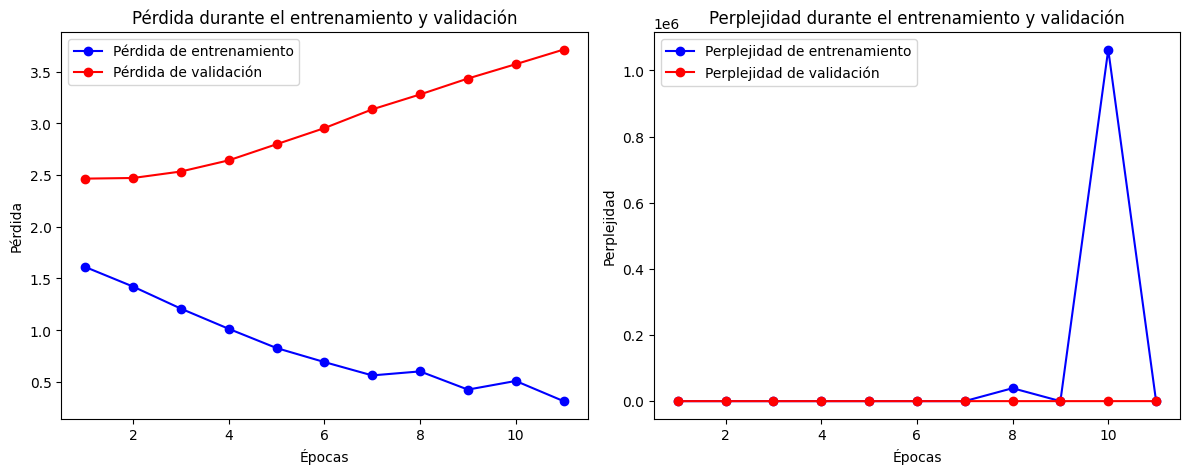

In [78]:
# Obtener los valores del historial de entrenamiento
history_dict = hist.history

# Extraer el loss y el val_loss (loss en validación)
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Extraer la perplejidad
perplexity = history_dict['perplexity']
val_perplexity = history_dict['val_perplexity']

# Definir las épocas
epochs = range(1, len(loss) + 1)

# Graficar el loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'ro-', label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Graficar la perplejidad
plt.subplot(1, 2, 2)
plt.plot(epochs, perplexity, 'bo-', label='Perplejidad de entrenamiento')
plt.plot(epochs, val_perplexity, 'ro-', label='Perplejidad de validación')
plt.title('Perplejidad durante el entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Perplejidad')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

#### Generacion de sequencias

*Nuevamente, probamos la generación de secuencias:*

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Permite generar secuenchas de caracteres.</p></font></em>

In [79]:
def generate_char_seq(model, char2idx, idx2char, seed_text, n_chars):
    output_text = seed_text
    # Generar un número fijo de caracteres
    for _ in range(n_chars):
        # Tokenizamos la secuencia de entrada
        encoded = [char2idx[char] for char in output_text]

        # Expande la dimensión para simular un batch de tamaño 1 y ajusta el formato
        encoded = np.expand_dims(encoded, axis=(0, -1))

        # Predicción softmax
        y_hat = np.argmax(model.predict(encoded)[0, -1, :])

        # Convertir el índice predicho al carácter correspondiente
        predicted_char = idx2char[y_hat]

        # Agrego el carácter predicho al texto generado
        output_text += predicted_char

    return output_text

*Probamos algunas secuencias:*

In [80]:
input_text = "In a hole in the ground there lived a hobbit"
generate_char_seq(model, char2idx, idx2char, input_text, n_chars=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


'In a hole in the ground there lived a hobbition of the'

In [81]:
input_text = "The ring must be destroyed in the fires of Mount Doom"

# Genera una secuencia de 20 palabras a partir del texto inicial
generate_char_seq(model, char2idx, idx2char, input_text, n_chars=20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


'The ring must be destroyed in the fires of Mount Doom The Ring of the Rin'

##### Beam Search

*También nuevamente probamos Beam Search. En este punto hay que hacer varios cambios, entre los cuales se encuetran adaptar las funciones encode y decode, así como también las dimensiones de las otras funciones:*

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Funcinoes para hacer encoding y decoding de los carácteres.</p></font></em>

In [82]:
def encode(text, char2idx, max_length=max_context_size):
    # Convertir el texto de entrada en una secuencia de índices usando char2idx
    return [char2idx[char] for char in text if char in char2idx]


def decode(seq, idx2char):
    # Aplanar la secuencia si es un array multidimensional
    if isinstance(seq, np.ndarray):
        seq = seq.flatten().tolist()

    # Convertir la secuencia de índices en texto usando idx2char
    return "".join([idx2char.get(i, "") for i in seq])

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Función que selecciona candidatos para el beam search</p></font></em>

In [83]:
def select_candidates(
    pred, num_beams, vocab_size, history_probs, history_tokens, temp, mode
):
    # Recolectar todas las probabilidades para la siguiente búsqueda
    pred_large = []

    for idx, pp in enumerate(pred):
        pred_large.extend(np.log(pp + 1e-10) + history_probs[idx])

    pred_large = np.array(pred_large)

    # Criterio de selección
    if mode == "det":
        idx_select = np.argsort(pred_large)[::-1][
            :num_beams
        ]  # beam search determinista
    elif mode == "sto":
        idx_select = np.random.choice(
            np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large / temp)
        )  # beam search con muestreo aleatorio
    else:
        raise ValueError(
            f"Wrong selection mode. {mode} was given. det and sto are supported."
        )

    # Traducir a índices de token en el vocabulario
    selected_history_tokens = np.array(history_tokens)[idx_select // vocab_size]

    # Ajustamos el índice de selección para que tenga las mismas dimensiones que los tokens históricos
    new_tokens = np.expand_dims(idx_select % vocab_size, axis=-1)

    # Expandir las dimensiones de `new_tokens` para que coincidan con `selected_history_tokens`
    new_tokens = np.expand_dims(new_tokens, axis=-1)

    # Concatenamos las secuencias de tokens seleccionados con los nuevos tokens predichos
    new_history_tokens = np.concatenate((selected_history_tokens, new_tokens), axis=1)

    # Devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Realiza Beam Search:</p></font></em>

In [84]:
def beam_search(
    model, char2idx, idx2char, num_beams, num_chars, input_text, temp=1, mode="det"
):
    encoded = encode(input_text, char2idx)

    # (batch_size, sequence_length, 1)
    encoded = np.expand_dims(encoded, axis=(0, -1))

    y_hat = model.predict(encoded, verbose=0)[0, -1, :]
    vocab_size = y_hat.shape[0]
    history_probs = [0] * num_beams
    history_tokens = [encoded[0]] * num_beams

    history_probs, history_tokens = select_candidates(
        [y_hat], num_beams, vocab_size, history_probs, history_tokens, temp, mode
    )

    for i in range(num_chars - 1):
        preds = []
        for hist in history_tokens:
            # (1, sequence_length, 1)
            input_update = np.expand_dims(hist, axis=0)

            # (batch_size, sequence_length, 1)
            if input_update.shape[-1] != 1:
                input_update = np.expand_dims(input_update, axis=-1)

            # Hacer la predicción
            y_hat = model.predict(input_update, verbose=0)[0, -1, :]
            preds.append(y_hat)

        history_probs, history_tokens = select_candidates(
            preds, num_beams, vocab_size, history_probs, history_tokens, temp, mode
        )

    # Decodificar las secuencias finales
    return [decode(seq, idx2char) for seq in history_tokens]

*Probamos la misma generación que con palabras:*

In [85]:
input_text = "The ring must be destroyed in the fires of Mount Doom"

*Generación de forma determinista:*

In [86]:
generated_texts = beam_search(model, char2idx, idx2char, num_beams=5, num_chars=20, input_text=input_text)
for text in generated_texts:
    print(text)

The ring must be destroyed in the fires of Mount Doom The Ring of the Rin
The ring must be destroyed in the fires of Mount Doom The Rings of the Ri
The ring must be destroyed in the fires of Mount Doom The Ring of the Pas
The ring must be destroyed in the fires of Mount Doom The Rings of the Ro
The ring must be destroyed in the fires of Mount Doom The Ring of the Par


*Generación con temperatura 1:*

In [87]:
generated_texts = beam_search(model, char2idx, idx2char, num_beams=5, num_chars=50, input_text=input_text, temp=1, mode="sto")
for text in generated_texts:
    print(text)

The ring must be destroyed in the fires of Mount Doom The Shad The Paster The Wride in the Parter 1 Cha
The ring must be destroyed in the fires of Mount Doom The Shad The Paster The Wride in the Parter 1 Cha
The ring must be destroyed in the fires of Mount Doom The Shad The Paster The Wride in the Parter 1 Cha
The ring must be destroyed in the fires of Mount Doom The Shad The Paster The Wride in the Greater of t
The ring must be destroyed in the fires of Mount Doom The Shad The Paster The Wride in the Parter 1 Cha


*Generación con temperatura 0.5:*

In [88]:
generated_texts = beam_search(model, char2idx, idx2char, num_beams=5, num_chars=50, input_text=input_text, temp=0.5, mode="sto")
for text in generated_texts:
    print(text)

The ring must be destroyed in the fires of Mount Doom The Ring of the Paster The Ring of the Ring of th
The ring must be destroyed in the fires of Mount Doom The Ring of the Paster The Ring of the Ring of th
The ring must be destroyed in the fires of Mount Doom The Ring of the Paster The Ring of the Ring of th
The ring must be destroyed in the fires of Mount Doom The Ring of the Paster The Ring of the Ring of th
The ring must be destroyed in the fires of Mount Doom The Ring of the Paster The Ring of the Ring of th


⭐ <em><strong>Conclusión</strong></em> ⭐

<em><strong><p>Como conclusión, podemos ver que tuvimos overfitting, sin embargo, pudimos notar el aprendizaje de palabras a partir de carácteres. Esto nota que el modelo aprendió. Como la curva en entrenamiento es más baja, hay oportunidades de mejoras de este overfitting, tanto agregando regularizaciones como aumentando los datos (se tuvo que probar con un subconjunto debido a falta de GPU).</p></strong></em>

⚠️ <em><font color='gold'>Problemas detectados:</font></em>
<em><font color='gold'>
<p>

Algunos de los problemas detectados fueron:

1. Inicialmente se planteó resolver la métrica con un callback, lo que no se pudo dado que no se logueaba la métrica correctamente en kears, por lo que se tuvo que crear una métrica específica.
2. En el ambiente local funcionaba bien, pero cuando se fue a validar con más potencia de cómputo (Google Colab), aparecían valores NaN y no se calculaba la métrica de perplejidad. Esto se pensó que era porque había etiquetas con todos los valores en 0 (eran secuencias de una palabra que desplazadas daban todo 0), pero localmente no daba problemas. Igualmente, se probó poner una capa de Maskara (https://keras.io/api/layers/core_layers/masking/), pero hubieron problemas por el padding (las capas de Maskaras solicitan padding a la derecha). Finalmente, se probó filtrar también dichos registros y el problema seguía, así que se entrenó con menos datos. Falta más investigación para resolver este problema de Google Colab (puede venir por el uso de GPU, ya que con CPU no dio problemas). Se deja el código del workarround probado:

</p></font></em>

```python
# Workarround...
# Filtrar filas completamente ceros en el conjunto de entrenamiento
mask_train = np.any(X != 0, axis=1)  # Máscara para identificar filas con al menos un valor distinto de cero
X = X[mask_train]
y = y[mask_train]

print(f'Shape X después de eliminar filas ceros: {X.shape}')
print(f'Shape y después de eliminar filas ceros: {y.shape}')

# Filtrar filas completamente ceros en el conjunto de validación
mask_val = np.any(X_val != 0, axis=1)  # Máscara para identificar filas con al menos un valor distinto de cero
X_val = X_val[mask_val]
y_val = y_val[mask_val]

print(f'Shape X_val después de eliminar filas ceros: {X_val.shape}')
print(f'Shape y_val después de eliminar filas ceros: {y_val.shape}')
```

💫 <em><font color='MediumPurple'> Mejoras posibles: </font></em>
<em><font color='MediumPurple'>
<p>

Entre las mejoras posibles, se identificaron:

1. Probar varios modelos.
2. Hacer un ajuste de hiperparámetros, con distintas capas a probar.
3. Resolver correctamente el problema de la métrica en Colab.
4. Entrenar con más datos que la versión actual.
5. Solucionar problemas de overfitting.

</p></font></em>